In [30]:
# imports
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from transformers import AutoTokenizer

In [31]:
# define experiment constants

# results are saved in this directory
ROOT_DIR = "tmp/"
# the name of the experiment
EXPERIMENT_NAME = "en-100-1"
# path where the split datasets are stored
SOURCE_DIR = "./datasets"
# file name of the (split) tokenized version of the dataset
SOURCE_FILE = "train_dataset.npy"
# number of trials to run in the experiment
NUM_TRIALS = 1
# language of the setup
LANGUAGE = "en"
# split of the dataset to use
SPLIT = "train"
# path to the dataset raw files
DATASET_DIR = "nl-en"
# path to the dataset files
DATASET_FILE = "europarl-v7.nl-en"

# sequence parameters
SUFFIX_LEN = 50
PREFIX_LEN = 50
EXAMPLE_TOKEN_LEN = 100
PREPREFIX_LEN = 0

BATCH_SIZE = 32

MODEL = "EleutherAI/gpt-neo-125M"

In [28]:
# create config.json from constants
config = {
    "root_dir": ROOT_DIR,
    "experiment_name": EXPERIMENT_NAME,
    "dataset_dir": DATASET_DIR,
    "dataset_file": DATASET_FILE,
    "num_trials": NUM_TRIALS,
    "language": LANGUAGE,
    "split": SPLIT,
    "suffix_len": SUFFIX_LEN,
    "prefix_len": PREFIX_LEN,
    "example_token_len": EXAMPLE_TOKEN_LEN,
    "preprefix_len": PREPREFIX_LEN,
    "source_dir": SOURCE_DIR,
    "source_file": SOURCE_FILE,
    "batch_size": BATCH_SIZE,
    "model": MODEL
}

with open("config.json", "w") as f:
    json.dump(config, f, indent=4)

In [16]:
# 1. Split the examples into two parts: prefix and suffix (and preprefix)

# assumption: data is prepared in jsonlines format with sentences all of desired token length
!python split_dataset.py --config_file config.json

2024-05-30 22:17:43,344 - INFO
===== Starting dataset token split generation for language nl with token length 100 =====
2024-05-30 22:17:43,344 - INFO
Opened file: nl-en/europarl-v7.nl-en-100.nl.jsonl
2024-05-30 22:17:43,351 - INFO
Processed 32 lines
2024-05-30 22:17:43,357 - INFO
Processed 64 lines
2024-05-30 22:17:43,362 - INFO
Processed 96 lines
2024-05-30 22:17:43,367 - INFO
Processed 128 lines
2024-05-30 22:17:43,371 - INFO
Processed 160 lines
2024-05-30 22:17:43,377 - INFO
Processed 192 lines
2024-05-30 22:17:43,382 - INFO
Processed 224 lines
2024-05-30 22:17:43,386 - INFO
Processed 256 lines
2024-05-30 22:17:43,391 - INFO
Processed 288 lines
2024-05-30 22:17:43,396 - INFO
Processed 320 lines
2024-05-30 22:17:43,401 - INFO
Processed 352 lines
2024-05-30 22:17:43,406 - INFO
Processed 384 lines
2024-05-30 22:17:43,411 - INFO
Processed 416 lines
2024-05-30 22:17:43,416 - INFO
Processed 448 lines
2024-05-30 22:17:43,420 - INFO
Processed 480 lines
2024-05-30 22:17:43,425 - INFO
Proce

In [1]:
# 2. Generate model output using prefixes as prompts

# run this directly in terminal, model cannot be loaded in notebook due to memory constraints I think, crashes kernel

# will not overwrite results
!python extraction.py --config_file config.json

2024-05-30 23:12:58,729 - INFO
Parsing arguments...
2024-05-30 23:12:58,736 - INFO
Default device: mps
2024-05-30 23:12:58,736 - INFO
Loading tokenizer...
2024-05-30 23:12:59,093 - INFO
Loading model...


In [10]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")

# Function to generate a jsonlines version of dataset
# input here is a numpy array of tokenized data (using token IDs)
def generations_to_jsonl(output_file_path: str, data: np.ndarray):
    """Converts the tokenized data to a JSONL file at `path`."""

    with open(output_file_path, "w", encoding="utf-8", newline='') as file:
        id = 0
        for row in data:
            # Convert token IDs to strings
            # replace token space character with empty string
            decoded_string = tokenizer.decode(row, skip_special_tokens=True).replace('Ġ', '')
            line = decoded_string.strip()

            # Skip empty lines
            if not line:
                continue

            # Create a JSON object with a "text" field containing the line
            json_object = {"exid": id,
                           "text": line}

            # Write the JSON object to the output file as a single line
            json.dump(json_object, file, ensure_ascii=False)
            file.write("\n")
            id += 1

    print("Decoded strings saved to: %s", str(output_file_path))

In [12]:
# Convert original prefix and suffix npy arrays to jsonlines format for evaluation
np_dataset_base = os.path.join(SOURCE_DIR, LANGUAGE, str(EXAMPLE_TOKEN_LEN))

prefix_file = os.path.join(np_dataset_base, f"{SPLIT}_prefix.npy")
suffix_file = os.path.join(np_dataset_base, f"{SPLIT}_suffix.npy")

prefixes = np.load(prefix_file)
suffixes = np.load(suffix_file)

generations_to_jsonl(np_dataset_base + f"/{SPLIT}_prefix.jsonl", prefixes)
generations_to_jsonl(np_dataset_base + f"/{SPLIT}_suffix.jsonl", suffixes)

Decoded strings saved to: %s ./datasets/nl/200/train_prefix.jsonl
Decoded strings saved to: %s ./datasets/nl/200/train_suffix.jsonl


In [15]:
experiment_base = os.path.join(ROOT_DIR, LANGUAGE, EXPERIMENT_NAME)
for i in range(0, NUM_TRIALS):
        file_path = os.path.join(experiment_base, f"generations/{i}.npy")
        data = np.load(file_path)
        
        output_file_path = os.path.join(experiment_base, f"decoded/decoded_strings_trial_{i}.jsonl")
        output_dir = os.path.dirname(output_file_path)
        os.makedirs(output_dir, exist_ok=True)
        generations_to_jsonl(output_file_path, data)

Decoded strings saved to: %s tmp/nl/test/decoded/decoded_strings_trial_0.jsonl
Decoded strings saved to: %s tmp/nl/test/decoded/decoded_strings_trial_1.jsonl
Decoded strings saved to: %s tmp/nl/test/decoded/decoded_strings_trial_2.jsonl
Decoded strings saved to: %s tmp/nl/test/decoded/decoded_strings_trial_3.jsonl
Decoded strings saved to: %s tmp/nl/test/decoded/decoded_strings_trial_4.jsonl
Decoded strings saved to: %s tmp/nl/test/decoded/decoded_strings_trial_5.jsonl
Decoded strings saved to: %s tmp/nl/test/decoded/decoded_strings_trial_6.jsonl


In [17]:
# 3. Evaluate the model output against the dataset
!python evaluation.py --config_file config.json

wandb: Currently logged in as: anna-visman (annavisman). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /Users/annavisman/stack/RUG/CS/Year3/thesis/thesis-llm-privacy/wandb/run-20240529_135530-phgonu23
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run warm-pond-5
wandb: ⭐️ View project at https://wandb.ai/annavisman/thesis-llm-privacy
wandb: 🚀 View run at https://wandb.ai/annavisman/thesis-llm-privacy/runs/phgonu23
2024-05-29 13:55:33,474 - INFO
===== Starting evaluation of similarity between generated and original text in language nl for 50 prefix & suffix length =====
2024-05-29 13:55:33,479 - INFO
Starting BLEU-score evaluation for trial 0
/opt/miniconda3/envs/torch/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower ord

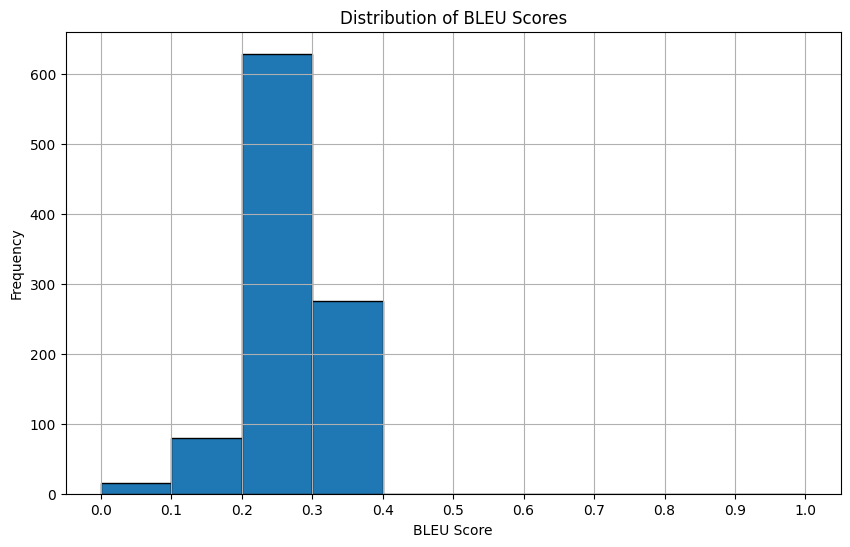

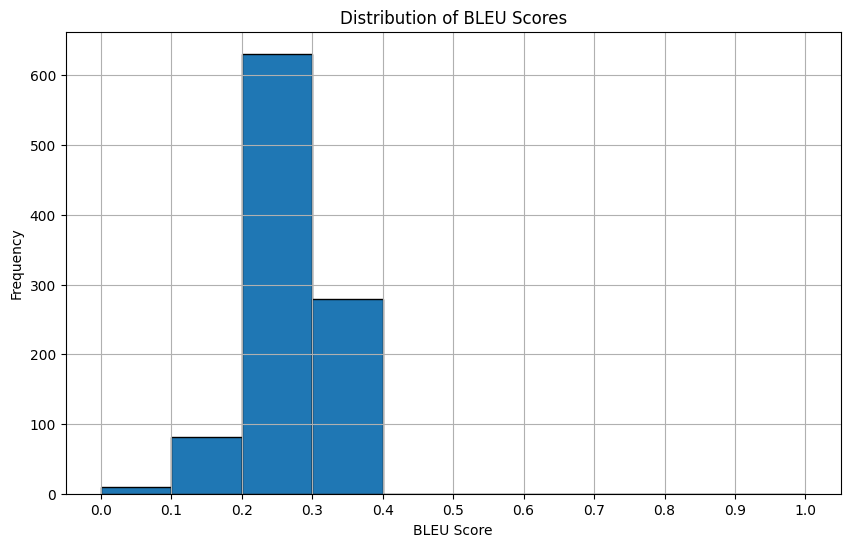

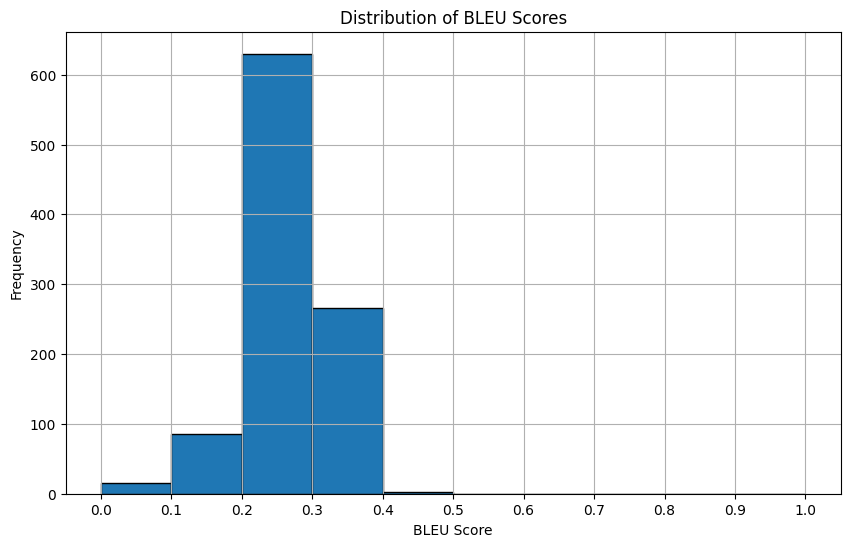

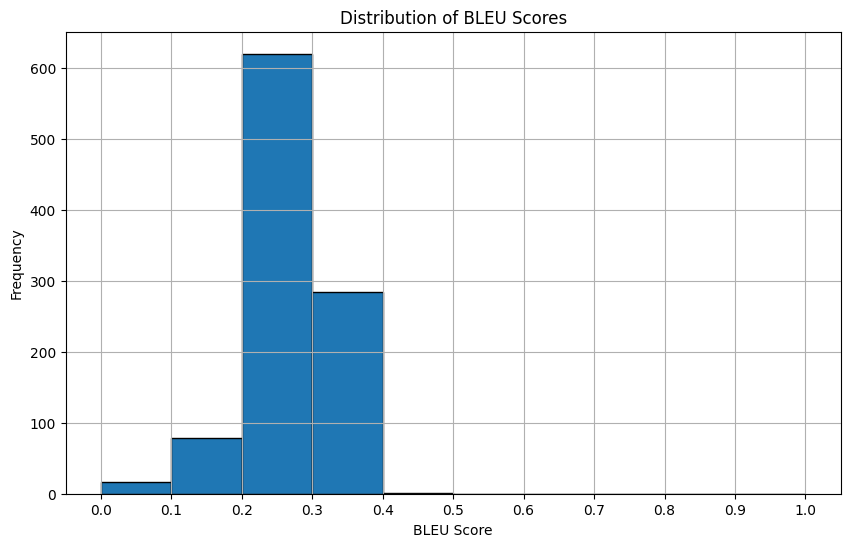

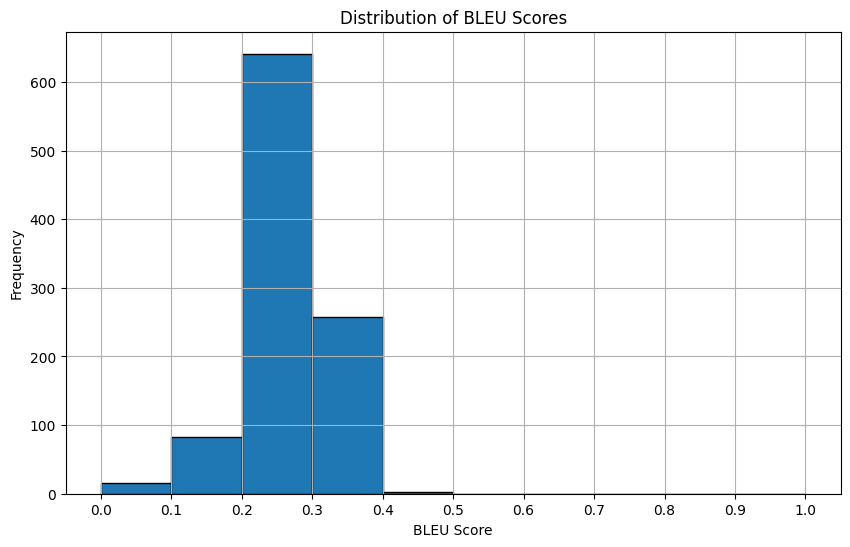

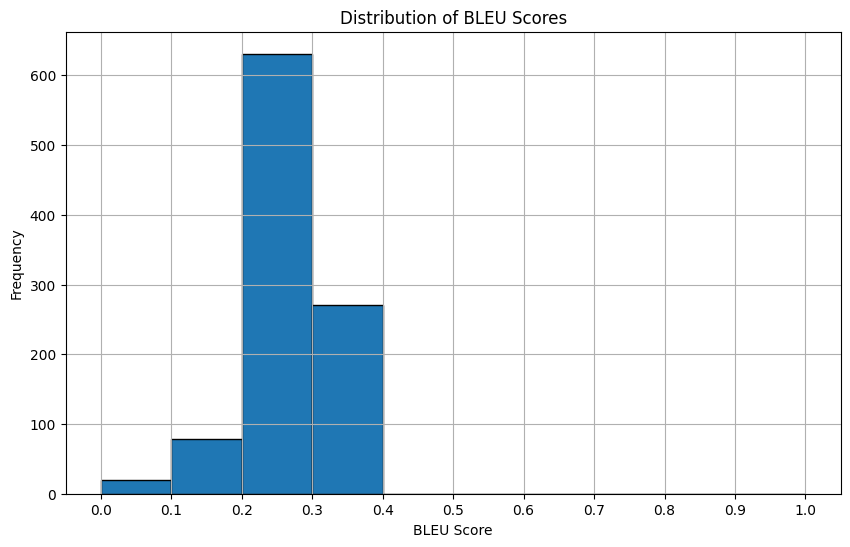

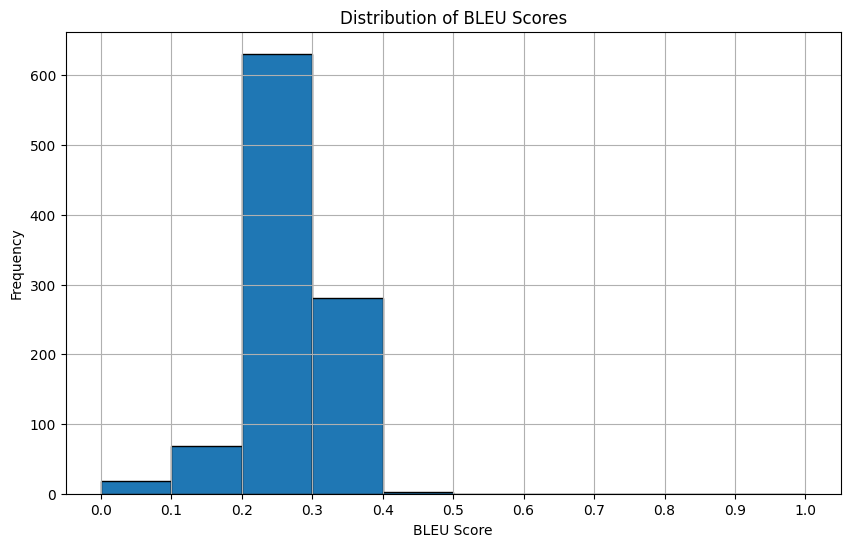

In [18]:
# 4. Plot distribution of scores

def read_bleu_scores(file_path):
    scores = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data = json.loads(line)
            scores.append(data['score'])
    return scores

def plot_bleu_distribution(scores, trial, num_bins=10):
    plt.figure(figsize=(10, 6))
    
    # Compute histogram
    counts, bins = np.histogram(scores, bins=num_bins, range=(0, 1))
    
    # Plot histogram as bar chart
    plt.bar(bins[:-1], counts, width=(bins[1] - bins[0]), edgecolor='black', align='edge')

    # add a grid on image
    plt.grid(True)

    # Set titles and labels
    plt.title('Distribution of BLEU Scores')
    plt.xlabel('BLEU Score')
    plt.ylabel('Frequency')
    
    plt.xticks(np.linspace(0, 1, num_bins + 1))

    # create a directory
    plots_dir = os.path.join(ROOT_DIR, EXPERIMENT_NAME, "plots")
    os.makedirs(plots_dir, exist_ok=True)

    # save the file
    plt.savefig(os.path.join(plots_dir, f"bleu_distribution_trial_{trial}.png"))
    
    # Show plot
    plt.show()

if __name__ == "__main__":

    for i in range(NUM_TRIALS):
    
        # Path to the .jsonl file containing BLEU scores
        bleu_scores_file = os.path.join(ROOT_DIR, LANGUAGE, EXPERIMENT_NAME, "scores", f"bleu_scores_trial_{i}.jsonl")
        
        # Read BLEU scores from the file
        bleu_scores = read_bleu_scores(bleu_scores_file)
        
        # Plot the distribution of BLEU scores
        plot_bleu_distribution(bleu_scores, i)

In [39]:
# get the shape of a numpy array
def get_shape(arr):
    if isinstance(arr, np.ndarray):
        return arr.shape
    return None

# load the dataset
dataset = np.load("tmp/nl/test/generations/0.npy")
print(get_shape(dataset))




(1000, 100)
